In [36]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'IWF'
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_iwf.pkl' # Russell 1000
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(6069, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2000-05-26,78.187500,78.187500,78.140625,78.140625,60.144848,4.096756,0.999400,1.018996,1.017197
2000-05-30,79.484375,79.625000,79.484375,79.625000,61.287350,4.115573,1.001769,1.031005,1.016876
2000-05-31,80.968750,82.093750,80.968750,82.093750,63.187542,4.146107,1.013894,1.009516,0.999429
2000-06-01,82.046875,83.187500,82.046875,82.875000,63.788857,4.155579,1.010093,1.036388,1.031863
2000-06-02,85.515625,85.890625,85.234375,85.890625,66.110001,4.191320,1.004385,0.994179,0.991086
2000-06-05,85.125000,86.000000,85.125000,85.390625,65.725197,4.185482,1.003120,1.002561,0.999817
2000-06-06,85.375000,85.671875,85.375000,85.609375,65.893539,4.188040,1.002745,0.996167,0.985946
2000-06-07,84.406250,85.281250,84.406250,85.281250,65.640961,4.184200,1.010367,0.993771,1.004031
2000-06-08,85.625000,85.640625,84.750000,84.750000,65.232056,4.177951,0.989781,1.003503,1.010693


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2000-05-26     78.187500
2000-05-30     79.625000
2000-05-31     82.093750
2000-06-01     83.187500
2000-06-02     85.890625
                 ...    
2024-07-08    378.910004
2024-07-09    380.730011
2024-07-10    382.820007
2024-07-11    382.630005
2024-07-12    379.850006
Name: high, Length: 6066, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2000-05-26')  # first day of legit open/close values
SIM_START

Timestamp('2000-05-26 00:00:00')

In [7]:
len(df.index >= SIM_START)

6069

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

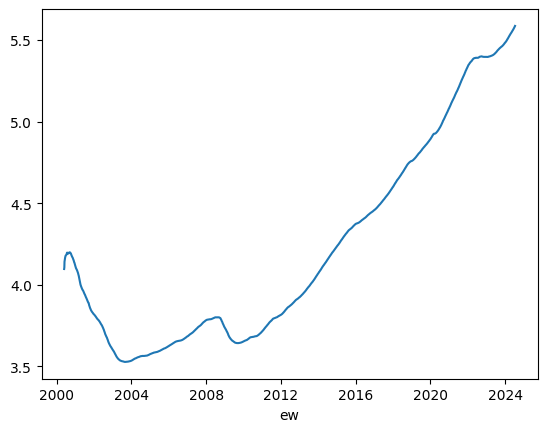

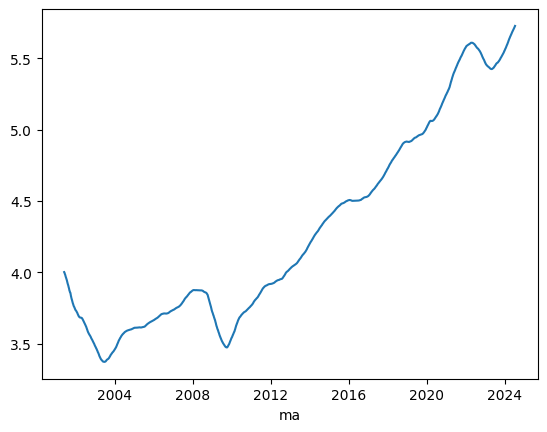

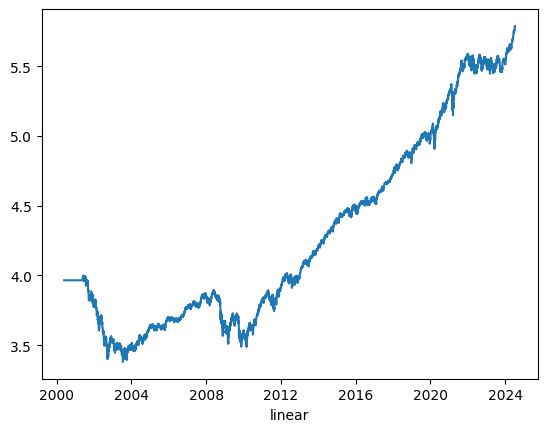

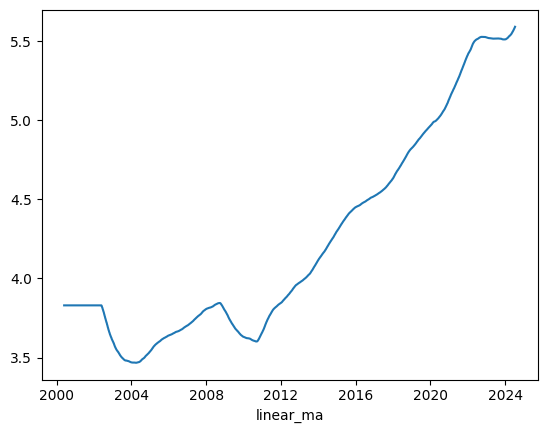

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(None, None)

Do nothing res: 6.265374340750844
Round 1: 6.669223382891797
New best: 6.669223382891797
{'time_param': 155, 'method': 'ew', 't': 0.3160390607154191, 'k': 0.20726832673682052, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


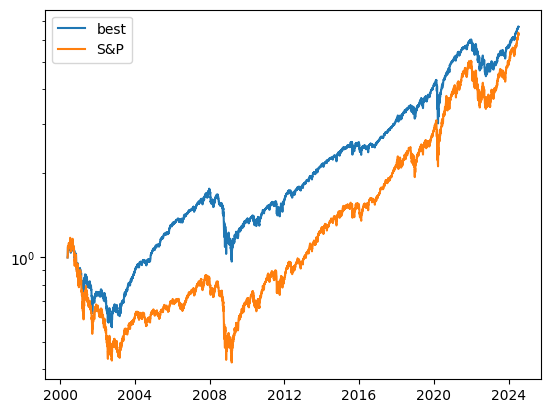

Round 2: 48.549181194211116
New best: 48.549181194211116
{'time_param': 207, 'method': 'linear_ma', 't': 0.8646762973591853, 'k': 5.561573668122516, 'as_q': False, 'transform_f': 'bounded_curve'}


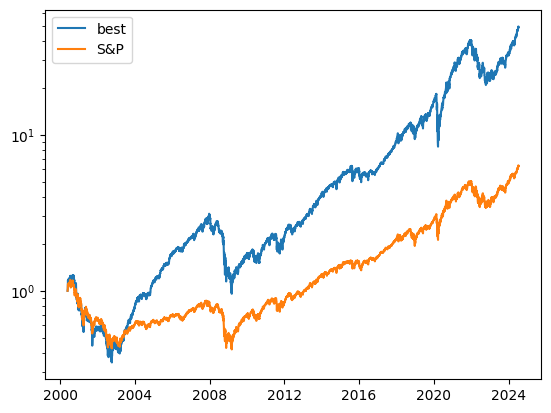

Round 3: 48.13539382536849
Round 4: 6.97229986675526
Round 5: 1.5954395297060262
Round 6: 8.28317659170941
Round 7: 9.615977807107187
Round 8: 1.2042344194993888
Round 9: 28.039497790848344
Round 10: 24.316125715998073
Round 11: 1.2160094489236584
Round 12: nan
Round 13: 1.710444563189022
Round 14: 8.055747443132798
Round 15: 25.877125312128406
Round 16: 6.666276015159895
Round 17: 50.689265403241386
New best: 50.689265403241386
{'time_param': 210, 'method': 'linear', 't': 0.892432487157709, 'k': 9.586478894851739, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


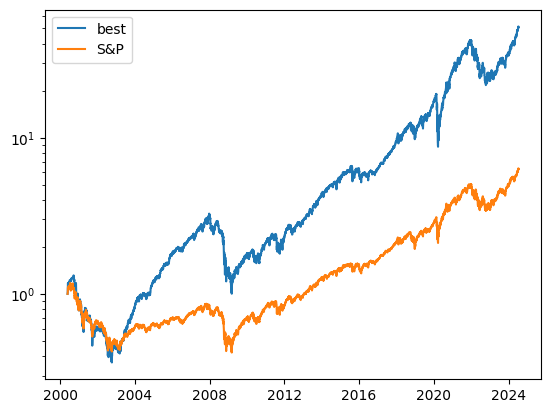

Round 18: nan
Round 19: 12.353980979048469
Round 20: nan
Round 21: 4.973605265757427
Round 22: 11.947418856458638
Round 23: 2.634125322219739
Round 24: 25.52637391899151
Round 25: 8.027171511476682
Round 26: 2.0179547306052728
Round 27: 20.0632536834798
Round 28: 3.3020779778787106
Round 29: 1.570075121631374
Round 30: 1.1007445907650282
Round 31: 5.867894950356027
Round 32: nan
Round 33: 1.307871040088033
Round 34: 1.1375951288395638
Round 35: 4.019997643546094
Round 36: 21.420023093683795
Round 37: 44.01441632781486
Round 38: 52.95771246705358
New best: 52.95771246705358
{'time_param': 218, 'method': 'linear_ma', 't': 0.9878197833598463, 'k': 1.3306194058089373, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


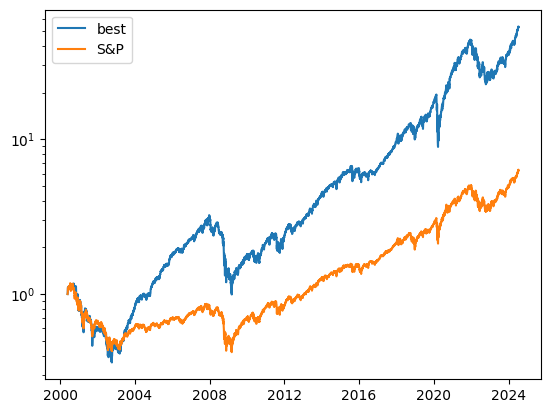

Round 39: nan
Round 40: nan
Round 41: 11.720924718131103
Round 42: 1.3714676847147464
Round 43: 1.6187200538271376
Round 44: 4.976831872458702
Round 45: 1.1495118878733284
Round 46: 5.410791698748739
Round 47: 1.729997810058565
Round 48: 10.230189299468371
Round 49: 2.764913937638349
Round 50: 6.945212448826101
Round 51: 4.842199033866561
Round 52: 20.898023045675426
Round 53: nan
Round 54: 0.8702574168526045
Round 55: 1.2486940485742066
Round 56: 35.185382663974536
Round 57: nan
Round 58: nan
Round 59: 3.854846185855741
Round 60: nan
Round 61: 47.64851635975779
Round 62: 1.750489020373872
Round 63: 1.4075770402925287
Round 64: nan
Round 65: 6.826210106095324
Round 66: nan
Round 67: 1.238383473493552
Round 68: 1.3094921664276984
Round 69: 1.0780499180876348
Round 70: 0.8786864356974886
Round 71: 9.024376474312822
Round 72: 9.011064530446088
Round 73: nan
Round 74: 13.048175481628952
Round 75: 0.7836720989400058
Round 76: 6.622070870505457
Round 77: 1.8866426056214634
Round 78: 46.04085

In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 6.265374340750844
Round 1: 33.94849795674942
Round 2: 26.95180927723992
Round 3: 48.36619310129464
Round 4: 6.10884479448754
Round 5: 10.017085442008124
Round 6: 48.35197546715169
Round 7: 51.285424390972686
Round 8: 48.37027557412064
Round 9: 48.35657675728868
Round 10: 51.30457987374106
Round 11: 3.7963862752472433
Round 12: 48.354644073780044
Round 13: 21.936190465123435
Round 14: 20.48548377259078
Round 15: 48.34917528107214
Round 16: 48.36959483872393
Round 17: 48.35767465424419
Round 18: 53.431196029825905
New best: 53.431196029825905
{'time_param': 224, 'method': 'linear_ma', 't': 0.9583373777404808, 'k': 1.3066972010829039, 'as_q': True, 'transform_f': 'bounded_curve'}


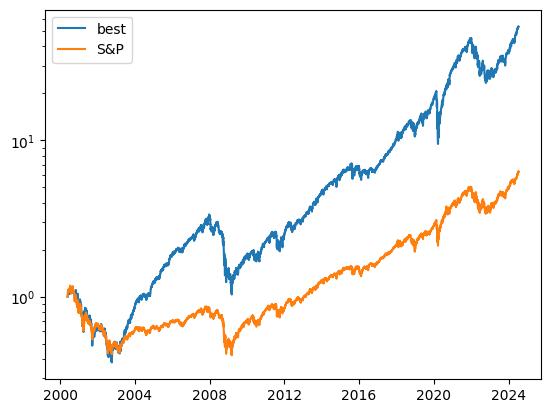

Round 19: 48.09651752760891
Round 20: 48.15044000434684
Round 21: 3.76159971533259
Round 22: 3.8959584331904864
Round 23: 13.054925031520524
Round 24: 12.368050416147726
Round 25: 26.661215820908662

Factor: 1.03125
Do nothing res: 6.265374340750844
Round 1: 48.097158248446036
Round 2: 48.08613886897701
Round 3: 19.737104300509664
Round 4: 48.08157861021606
Round 5: 48.1231620621978
Round 6: 48.083673151078585
Round 7: 48.08351211063826
Round 8: 48.363117023371586
Round 9: 48.10875676143322
Round 10: 53.51043792240466
New best: 53.51043792240466
{'time_param': 229, 'method': 'linear_ma', 't': 0.96002382867718, 'k': 1.2725854841690794, 'as_q': True, 'transform_f': 'bounded_curve'}


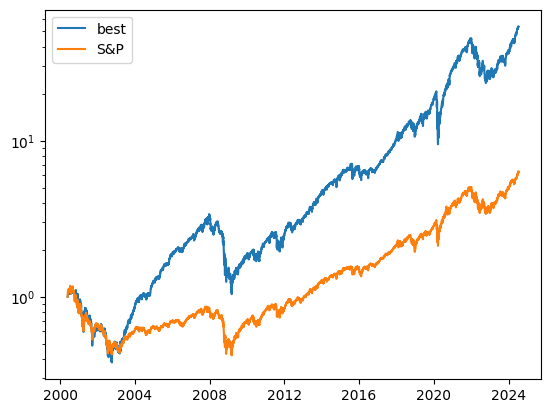

Round 11: 48.14746689690664
Round 12: 48.13021570960124
Round 13: 48.1412075881733
Round 14: 48.14515775161738
Round 15: 3.0121477537273793
Round 16: 48.14141044761044
Round 17: 48.12876073068235
Round 18: 30.73700992749264
Round 19: 10.462066290193352
Round 20: 48.099602075518625
Round 21: 20.32300097045998
Round 22: 48.12784492068295
Round 23: 21.35970197535859
Round 24: 48.102617493254435
Round 25: 7.321014962200187

Factor: 1.015625
Do nothing res: 6.265374340750844
Round 1: 48.11124628893736
Round 2: 13.029326765574663
Round 3: 48.74830855103713
Round 4: 5.6971353042182065
Round 5: 30.340947742556565
Round 6: 35.29078709863862
Round 7: 48.113104399678974
Round 8: 48.11811046364612
Round 9: 48.12342208826798
Round 10: 48.12224722046486
Round 11: 10.320570568453688
Round 12: 10.57901195064773
Round 13: 48.133067400378614
Round 14: 48.126160575351804
Round 15: 48.11139458537632
Round 16: 48.12280103601604
Round 17: 48.1222383179553
Round 18: 6.761417577331115
Round 19: 26.02466862571

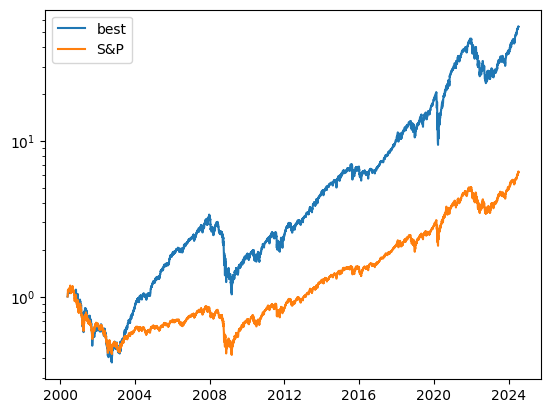

Round 9: 48.129983307144336
Round 10: 48.13169220815076
Round 11: 48.13256981669391
Round 12: 37.77949568387176
Round 13: 48.130864321513386
Round 14: 48.12311113779886
Round 15: 54.616233333890314
New best: 54.616233333890314
{'time_param': 226, 'method': 'linear_ma', 't': 0.9767487127130003, 'k': 1.254748115041955, 'as_q': True, 'transform_f': 'bounded_curve'}


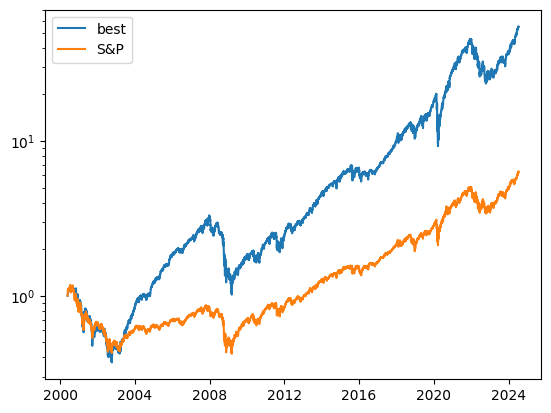

Round 16: 48.13124072664913
Round 17: 48.1366128388929
Round 18: 48.1391456242184
Round 19: 48.139933254626925
Round 20: 46.70968577815219
Round 21: 48.138144502003165
Round 22: 12.856614077149422
Round 23: 48.12932209818384
Round 24: 48.13987565092525
Round 25: 43.472880259660535



In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [20]:
stop

NameError: name 'stop' is not defined

In [21]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [22]:
final_out = simulate(df, params_out)

In [23]:
amt_in = final_out['amt_in'][-1]
amt_in

0.7010661267892979

In [24]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.9678642056690837

In [25]:
params_out

{'time_param': 226,
 'method': 'linear_ma',
 't': 0.9767487127130003,
 'k': 1.254748115041955,
 'as_q': True,
 'transform_f': 'bounded_curve'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:24: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + x**(np.log(2) / np.log(t)) - 1) ** k


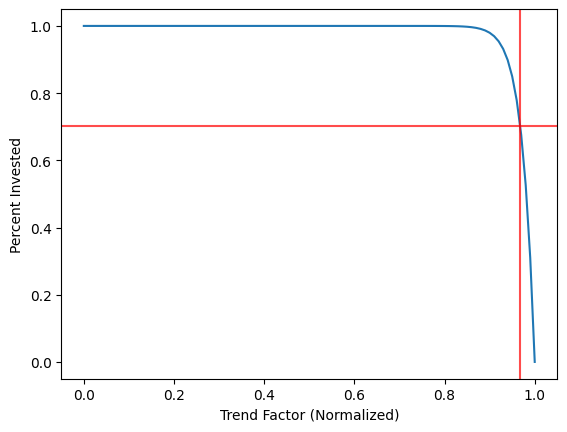

In [26]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

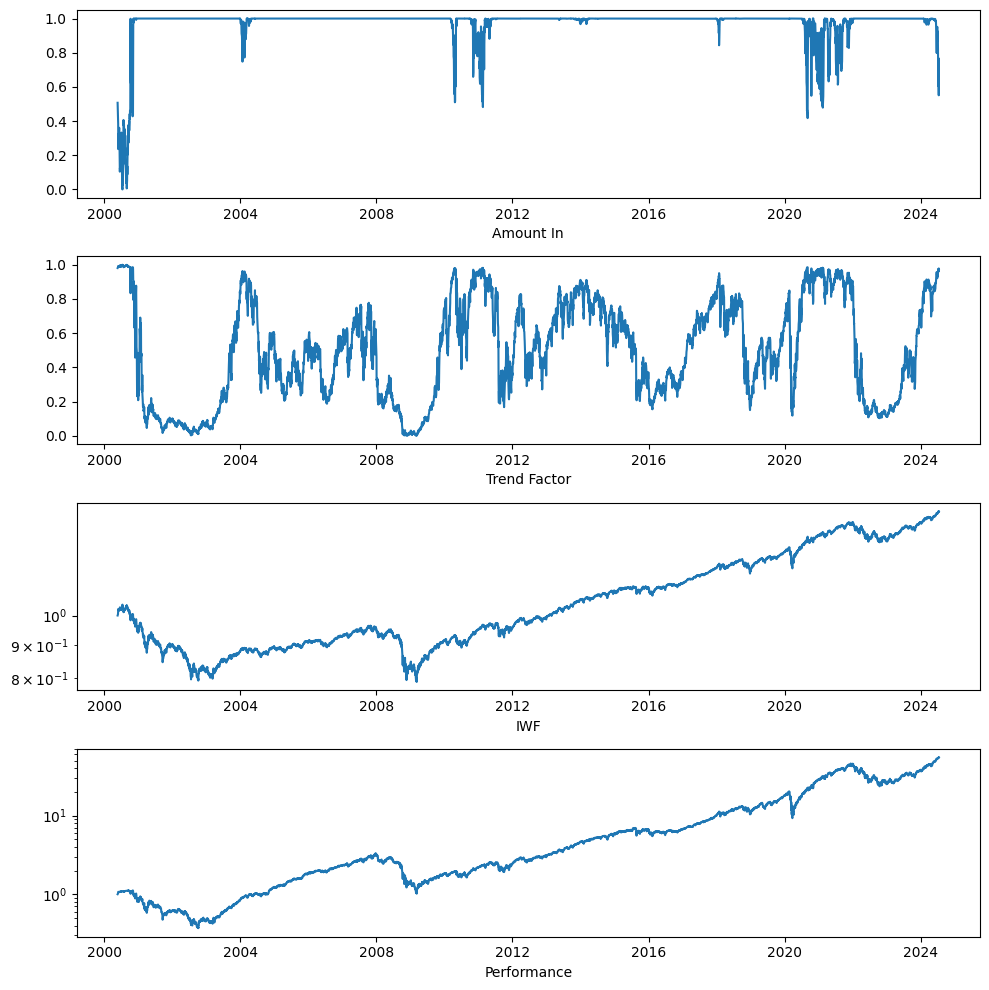

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('IWF')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

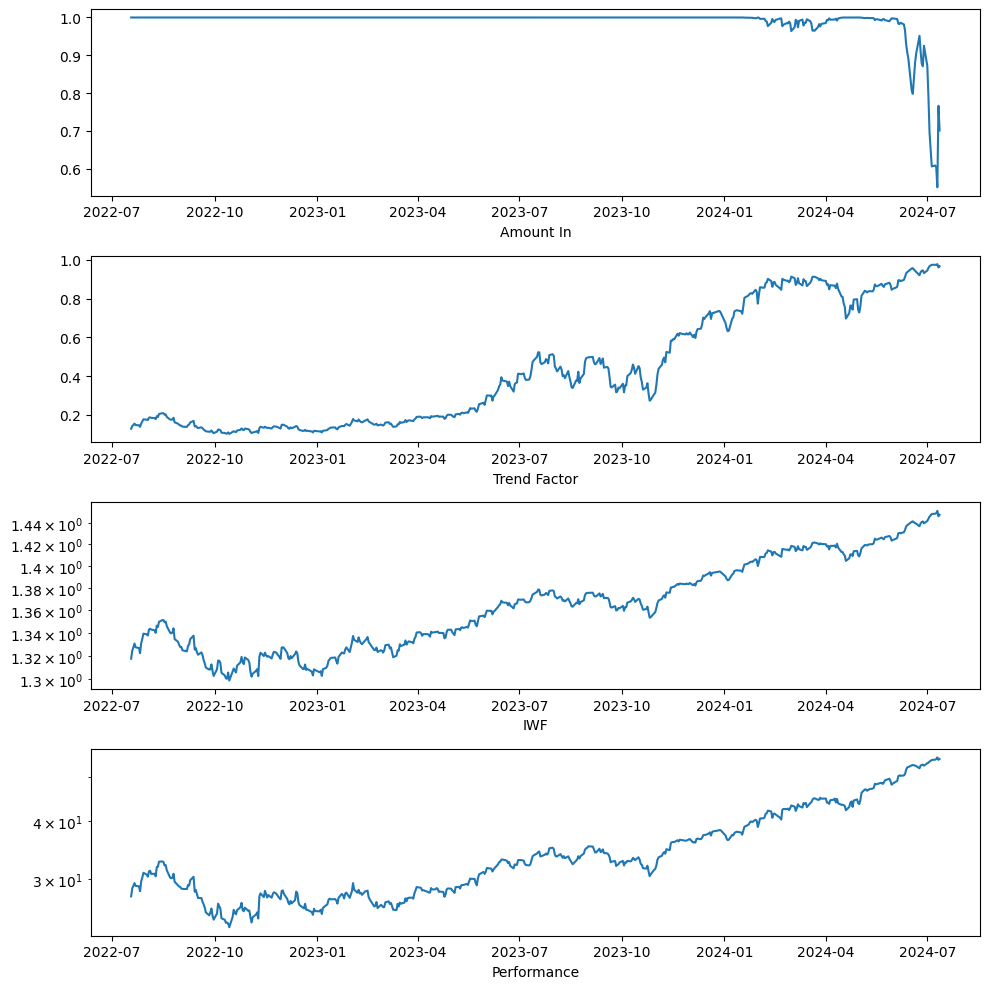

In [30]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('IWF')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [31]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(54.616233333890314,
 {'time_param': 226,
  'method': 'linear_ma',
  't': 0.9767487127130003,
  'k': 1.254748115041955,
  'as_q': True,
  'transform_f': 'bounded_curve'})

In [37]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.7011

In [38]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(60.14484786987305, 24.276, 376.8299865722656)

In [39]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.17914008608557896

In [41]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['rus'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.117876849072677, 0.9707], 'nas': [1.221824877675853, 0.9613], 'rus': [1.179140086085579, 0.7011]}
